# HW8 due 5p Fri Dec 3

You are welcome (and encouraged) to work with others, but each individual must submit their own writeup.

You are welcome to use analytical and numerical computational tools; if you do, include the **commented** sourcecode in your submission (e.g. the .ipynb file).

You are welcome to consult websites, textbooks, and other materials; if you do, include a full citation in your writeup (e.g. the .ipynb file).

**Important:** before you do any work in the Colaboratory notebook, click "File -> Save a copy in Drive ..." and rename the file to something memorable.

# 0. [Nakseung]; [Choi]

a. Approximately how many hours did you spend on this assignment?
  7 hrs
b. Were there specific problems that took much longer than others?

c. What class meeting(s) did you participate in this week?

d. What timezone(s) were you working in this week?

In [17]:
# "magic" commands, prefaced with "%", changes settings in the notebook

# this ensures plots are embedded in notebook web page
%matplotlib inline

# pdb = Python debugger, so this command turns the debugger OFF
%pdb off

Automatic pdb calling has been turned OFF


In [27]:
# import useful python packages
!pip install control
import numpy as np
import pylab as plt
from control import place as place

In [18]:
# numpy = numerical Python, implements arrays (/ matrices)
import numpy as np
# limit number of decimal places printed for floating-point numbers
np.set_printoptions(precision=3)

# scipy = scientific Python, implements operations on arrays / matrices
import scipy as sp
# linalg = linear algebra, implements eigenvalues, matrix inverse, etc
from scipy import linalg as la
# optimize = optimization, root finding, etc
from scipy import optimize as op

# produce matlab-style plots
import matplotlib as mpl
# increase font size on plots
mpl.rc('font',**{'size':18})
# use LaTeX to render symbols
mpl.rc('text',usetex=False)
# render animation
mpl.rc('animation',html='html5')
# animation
from matplotlib import animation as ani
# Matlab-style plotting
import matplotlib.pyplot as plt

# symbolic computation, i.e. computer algebra (like Mathematica, Wolfram Alpha)
import sympy as sym


In [19]:
# os = operating system; access OS-level commands
# e.g. create directory, delete file, execute command
# (more platform-independent than "!")
import os

In [21]:
# test whether this is a Colaboratory or Jupyter notebook
try:
  import google.colab
  COLAB = True
  print('Colaboratory Notebook')
except:
  COLAB = False
  print('Jupyter Notebook')

Colaboratory Notebook


In [22]:
# Colab notebook
if COLAB:
  # pip = Python package manager; "!" means "run at system level"
  !pip install control
  !pip install JSAnimation
  
  # render SymPy equations nicely in Colaboratory Notebook
  def colab_latex_printer(exp,**options):
    from google.colab.output._publish import javascript
    url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
    javascript(url=url)
    return sym.printing.latex(exp,**options)
  
  sym.init_printing(use_latex="mathjax",latex_printer=colab_latex_printer)

# Jupyter notebook
else:
  init_printing(use_latex='mathjax')
    

# Python's Control Systems Toolbox
import control as ctrl

# SciPy module that implements many of the routines in ctrl
from scipy import signal as sig

     |████████████████████████████████| 339 kB 5.0 MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344928 sha256=a622fafbb4d076105e80b2a40a3e14ac8e59980f2a6c95b8275d7140f20b6796
  Stored in directory: /root/.cache/pip/wheels/5b/64/54/70faad181d7baff1184541ca00c9a2efa633acd0a811831d30
Successfully built control
  Created wheel for JSAnimation: filename=JSAnimation-0.1-py3-none-any.whl size=11425 sha256=63101284b4813ab87490f6a4b5b5b0f378c5b8c0f6abfb47ffa4bf1e01c2f6ca
  Stored in directory: /root/.cache/pip/wheels/0e/4e/3d/05fb8cca2646ee0bbfbce17c40a970f48d5e0698b9e5aaa91f
Successfully built JSAnimation


In [25]:
def Jacobian(g,y,d=1e-4):
  """
  approximate derivative via finite-central-differences 

  input:
    g - function - g : R^n -> R^m
    y - n array
    (optional)
    d - scalar - finite differences displacement parameter

  output:
    Dg(y) - m x n - approximation of Jacobian of g at y
  """
  # given $g:\mathbb{R}^n\rightarrow\mathbb{R}^m$:
  # $$D_y g(y)e_j \approx \frac{1}{2\delta}(g(y+\delta e_j) - g(y - \delta e_j)),\ \delta\ll 1$$
  e = np.identity(len(y))
  Dyg = []
  for j in range(len(y)):
      Dyg.append((.5/d)*(g(y+d*e[j]) - g(y-d*e[j])))
  return np.array(Dyg).T

def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(x,u) 

  input:
    f : R x X x U --> X - vector field
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]
  
  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)

# 1. state and output feedback

***Purpose:*** apply analytical and computational techniques to observe and control the state of a *nonlinear* system.

Consider the following model of a robot arm from Problem 2 of Homework 6 (hw6p2) that consists of a rigid rod of length $\ell$ attached to a point mass $m$ at one end and a rotational joint at the other end,

$$ \ m \ell^2 \ddot{\theta} = m g \ell \sin\theta - \gamma\dot{\theta} + \tau,\ y = \ell\sin\theta, $$

where 
$\gamma$ is a coefficient of friction for the rotational joint 
and 
$\tau$ is a torque applied by a motor attached to the rotational joint; use parameter values $m = 1$ kg, $\ell = 1$ m, $g = 9.81$ m sec$^{-2}$, $\gamma = 1$ in this problem.

a. Implement a simulation where you apply the observer from (hw6p2h.)  and controller from (hw6p2c.) to the ***nonlinear*** system (nonlinear dynamics and nonlinear output equation); provide overlaid plots of states versus time for the nonlinear system and linear controller to verify that (i) the state of the observer converges to the state of the nonlinear system and (ii) the state of the nonlinear system converges to the equilibrium.   

***Note:*** the nonlinear system and linear controller should be initialized at non-equal non-equilibrium initial conditions.

***Hint:*** the nonlinear system and linear controller should not be initialized too far from the equilibrium.

***Bonus:*** Demonstrate that the controller in (a.) fails to stabilize the nonlinear system to the equilibrium by initializing the nonlinear system and/or linear observer sufficiently far from the equilibrium.

***Takeaway:*** we can apply linear systems tools to synthesize a controller that stabilizes a nonlinear system ***near an equilibrium***.


[[13.81  5.  ]]
[[  -9.   ]
 [-100.806]]
(1001, 4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


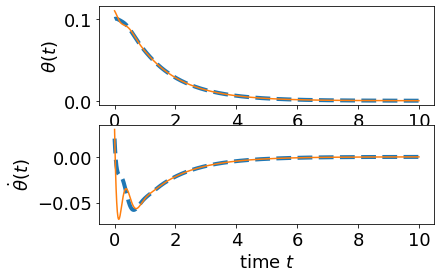

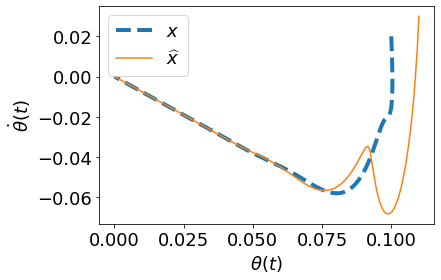

In [56]:
# Solution for 1 a
m = 1 # kg
ell = 1 # m
g = 9.81 # m/sec/sec
gamma = 1 
p = [-3. + np.sqrt(5),-3. - np.sqrt(5)]
K = ctrl.place(A,B,p)
print(K)
dt= 0.01

A = np.array([[0,1],[g/ell, -gamma/(m*ell**2)]])
B = np.array([[0],[1/(m*ell**2)]])
C = np.array([[ell, 0]])
D = np.array([[0]])
roots = [-5+8.66*1j, -5-8.66*1j] #Enter value

k1 = m*ell*g+4*m*ell**2
k2 = 4*m*ell**2 - gamma

L = -ctrl.place(A.T,C.T,roots).T
print(L)
def f_NL(t,x,u): # nonlinear system state dynamics
  theta = x[0]
  dtheta = x[1]
  ddtheta = g/ell*np.sin(theta) - gamma/(m*(ell**2))*dtheta + u/(m*(ell**2))  # - k1/(m*(ell**2))*theta - k2/(m*(ell**2))*dtheta
  dx = np.array([dtheta, ddtheta]).squeeze()
  return dx

def h_NL(t,x,u): # nonlinear system output dynamics
  theta = x[0]
  dtheta = x[1]
  y = ell * np.sin(theta)
  return np.array([[y]])

def f_cl(t,z,u): # closed-loop system
  x,x_hat = z[:2],z[2:]
  u = -np.dot(x_hat,K.T)
  
  y = h_NL(t,x,u)
  y_hat = ell * x_hat[0] # linearized 

  dx = f_NL(t,x,u)
  dx_hat = np.dot(x_hat,A.T) + np.dot(u,B.T) - np.dot(y-y_hat,L.T)
  dx_hat = np.array(dx_hat)
  dx_hat = dx_hat[0]
  # print( "dx.shape, dx_hat.shape", dx.shape, dx_hat.shape ) # debug

  # combine dynamics of controlled system and observer system
  dz = np.hstack((dx,dx_hat))
  return dz

# non-zero initial state
theta0 = 0.1
dtheta0 = 0.02
theta_hat0 = 0.11
dtheta_hat0 = 0.03
x0 = np.array([theta0, dtheta0, theta_hat0, dtheta_hat0])
T = 10
# zero input
def u(t):
  ut = 0
  return ut

# numerical simulation returns:
# t_ - size N array
# x_ - size N x 4 array (since the state is 2-dimensional)
t_,z_ = numerical_simulation(f_cl,T,x0,ut=u,dt=dt)
z_ = np.squeeze(z_)
print(z_.shape)

x_ = z_[:,:2]
x_hat_ = z_[:,2:]
theta_,dtheta_, = x_.T
theta_hat_,dtheta_hat_, = x_hat_.T


import pylab as plt
plt.figure()

# plot theta, theta_hat
plt.subplot(2,1,1)
plt.plot(t_,theta_,'--',lw=4,label=r'$\theta$')
plt.plot(t_,theta_hat_,label=r'$\widehat{\theta}$')
plt.ylabel(r'$\theta(t)$')

# plot dtheta, dtheta_hat
plt.subplot(2,1,2)
plt.plot(t_,dtheta_,'--',lw=4,label=r'$\dot{\theta}$')
plt.plot(t_,dtheta_hat_,label=r'$\dot{\widehat{\theta}}$')
plt.ylabel(r'$\dot{\theta}(t)$')
plt.xlabel(r'time $t$')

plt.figure()
plt.subplot(1,1,1)
plt.plot(theta_,dtheta_,'--',lw=4,label=r'$x$')
plt.plot(theta_hat_,dtheta_hat_,label=r'$\widehat{x}$')
plt.ylabel(r'$\dot{\theta}(t)$')
plt.xlabel(r'${\theta}(t)$')
plt.legend();

# 2. transfer functions

Consider the model of a series RLC circuit from lecture,
$$ L \ddot{q} + R \dot{q} + q/C = v, $$
where $q$ denotes the charge on the capacitor,
($R$, $L$, $C$) denote the (resistor, inductor, capacitor) parameters,
and $v$ denotes a series voltage source.

***Purpose:*** practice determining transfer functions from state-space representations of LTI systems.

a. Determine the transfer function from input voltage to capacitor charge $G_{qv}(s)$.

$$\boxed{{G_{qv}=\frac{q}{v}=\frac{1}{s^2L+sR+1/C}}}$$

b. With $x = (q,\dot{q})$ as the circuit's state, $u = v$ as the circuit's input, and $y = q$ as the circuit's output, determine matrices $A, B, C, D$ such that

$$ \dot{x} = A x + B u,\quad y = C x + D u. $$

$$\dot{x} = \left[\begin{matrix} \dot{q} \\ \ddot{q} \end{matrix}\right]=A\left[\begin{matrix} q\\ \dot{q} \end{matrix}\right] + Bv$$

$$\ddot{q}=\frac{v}{L}-\frac{R}{L}\dot{q}-\frac{q}{LC}$$

$$\dot{x} = \left[\begin{matrix} \dot{q} \\ \ddot{q} \end{matrix}\right]=\left[\begin{matrix} 0 & 1 \\ \frac{-1}{LC} & \frac{-R}{L} \end{matrix}\right] \left[\begin{matrix} q\\ \dot{q} \end{matrix}\right] + \left[\begin{matrix} 0 \\ \frac{1}{L} \end{matrix}\right]v$$

$$y=q=C\left[\begin{matrix} q\\ \dot{q} \end{matrix}\right]+Dv = \left[\begin{matrix} 1 & 0 \end{matrix}\right]+0v$$

$$\boxed{A=\left[\begin{matrix} 0 & 1 \\ \frac{-1}{LC} & \frac{-R}{L} \end{matrix}\right], B=\left[\begin{matrix} 0 \\ \frac{1}{L} \end{matrix}\right], C=\left[\begin{matrix} 1 & 0 \end{matrix}\right], D=0}$$


c. Verify that the transfer function of the state-space system in (b.) is the same as the transfer function determined in (a.).  (***Hint:***  you just need to compute $C (sI - A)^{-1} B + D$ and verify that it equals $G_{qv}(s)$).

$$C (sI - A)^{-1} B + D = \left[\begin{matrix} 1 & 0 \end{matrix}\right](\left[\begin{matrix} s & 0 \\ 0 & s \end{matrix}\right]-\left[\begin{matrix} 0 & 1 \\ \frac{-1}{LC} & \frac{-R}{L} \end{matrix}\right])^{-1}\left[\begin{matrix} 0 \\ \frac{1}{L} \end{matrix}\right]+0 = \left[\begin{matrix} 1 & 0 \end{matrix}\right](\left[\begin{matrix} s & -1 \\ \frac{1}{LC} & s+\frac{R}{L} \end{matrix}\right])^{-1}\left[\begin{matrix} 0 \\ \frac{1}{L} \end{matrix}\right]$$

$$C (sI - A)^{-1} B + D = \left[\begin{matrix} 1 & 0 \end{matrix}\right](\left[\begin{matrix} s & -1 \\ \frac{1}{LC} & s + \frac{R}{L} \end{matrix}\right])^{-1}\left[\begin{matrix} 0 \\ \frac{1}{L} \end{matrix}\right]+0 
= \frac{1}{s^2 + \frac{R}{L}s + \frac{1}{LC}}(\left[\begin{matrix} 1 & 0 \end{matrix}\right](\left[\begin{matrix} s+\frac{R}{L} & 1 \\ \frac{-1}{LC} & s \end{matrix}\right])\left[\begin{matrix} 0 \\ \frac{1}{L} \end{matrix}\right])
= \frac{1}{s^2 + \frac{R}{L}s + \frac{1}{LC}}(\left[\begin{matrix} s + \frac{R}{L} & 1 \end{matrix}\right]\left[\begin{matrix} 0 \\ \frac{1}{L} \end{matrix}\right])$$

$$\boxed{G_{qv} = \frac{1}{s^2L+sR+1/C}}$$

d. With $\widetilde{x} = (\frac{1}{2}(q + \dot{q}),\frac{1}{2}(q - \dot{q}))$ as the state, $u = v$ as the input, and $y = q$ as the output, determine matrices $\widetilde{A}, \widetilde{B}, \widetilde{C}, \widetilde{D}$ such that

$$ \dot{\widetilde{x}} = \widetilde{A} \widetilde{x} + \widetilde{B} u,\quad y = \widetilde{C} \widetilde{x} + \widetilde{D} u. $$

$$\widetilde{A}= TAT^{-1} , \widetilde{B} = TB$$

$$ \widetilde{x} = Tx$$

$$\left[\begin{matrix} \frac{1}{2}(q + \dot{q}) \\ \frac{1}{2}(q - \dot{q}) \end{matrix}\right] = \left[\begin{matrix} \frac{1}{2} & \frac{1}{2} \\ \frac{1}{2} & \frac{-1}{2} \end{matrix}\right]\left[\begin{matrix} q \\ \dot{q} \end{matrix}\right]$$

$$\widetilde{A} = \left[\begin{matrix} \frac{1}{2} & \frac{1}{2} \\ \frac{1}{2} & \frac{-1}{2} \end{matrix}\right] \left[\begin{matrix} 0 & 1 \\ \frac{-1}{LC} & \frac{-R}{L} \end{matrix}\right] \left[\begin{matrix} 1 & 1 \\ 1 & -1 \end{matrix}\right]$$

$$\Leftrightarrow \left[\begin{matrix} \frac{-(RC-LC+1)}{2LC} & \frac{RC-LC-1}{2LC} \\ \frac{RC+LC+1}{2LC} & \frac{-(RC+LC-1)}{2LC} \end{matrix}\right]$$

$$\widetilde{B} = \left[\begin{matrix} \frac{1}{2} & \frac{1}{2} \\ \frac{1}{2} & \frac{-1}{2} \end{matrix}\right] \left[\begin{matrix} 0 \\ \frac{1}{L} \end{matrix}\right] = \left[\begin{matrix} \frac{1}{2L} \\ \frac{-1}{2L} \end{matrix}\right]$$


$$\Leftrightarrow \boxed{\widetilde{A}=\left[\begin{matrix} \frac{-(RC-LC+1)}{2LC} & \frac{RC-LC-1}{2LC} \\ \frac{RC+LC+1}{2LC} & \frac{-(RC+LC-1)}{2LC} \end{matrix}\right], \widetilde{B}=\left[\begin{matrix} \frac{1}{2L} \\ \frac{-1}{2L} \end{matrix}\right]}$$
 
$$y=q=\widetilde{C}\left[\begin{matrix} \frac{1}{2}(q + \dot{q})\\ \frac{1}{2}(q - \dot{q}) \end{matrix}\right]+\widetilde{D}u = \left[\begin{matrix} 1 & 1 \end{matrix}\right]+0u$$

$$\boxed{\widetilde{C}=\left[\begin{matrix} 1 & 1 \end{matrix}\right], \widetilde{D}=0}$$

e. Verify that the transfer function of the state-space system in (d.) is the same as the transfer functions obtained in (a.), (c.).  (***Hint:***  you just need to compute $\widetilde{C} (sI - \widetilde{A})^{-1} \widetilde{B} + \widetilde{D}$ and verify that it equals $G_{qv}(s)$).

$$\widetilde{C} (sI - \widetilde{A})^{-1} \widetilde{B} + \widetilde{D}$$

$$ \Leftrightarrow \left[\begin{matrix} 1 & 1 \end{matrix}\right] (\left[\begin{matrix} s & 0 \\ 0 & s \end{matrix}\right] - \left[\begin{matrix} \frac{-(RC-LC+1)}{2LC} & \frac{RC-LC-1}{2LC} \\ \frac{RC+LC+1}{2LC} & \frac{-(RC+LC-1)}{2LC} \end{matrix}\right])^{-1} \left[\begin{matrix} \frac{1}{2L} \\ \frac{-1}{2L} \end{matrix}\right]$$

$$ \Leftrightarrow \left[\begin{matrix} 1 & 1 \end{matrix}\right] (\left[\begin{matrix} s + \frac{(RC-LC+1)}{2LC} & -\frac{RC-LC-1}{2LC} \\ -\frac{RC+LC+1}{2LC} & s + \frac{(RC+LC-1)}{2LC} \end{matrix}\right])^{-1} \left[\begin{matrix} \frac{1}{2L} \\ \frac{-1}{2L} \end{matrix}\right]$$

$$\Leftrightarrow \left[\begin{matrix} 1 & 1 \end{matrix}\right]  \frac{1}{s^2 + (\frac{1}{2LC} - \frac{1}{2} + \frac{R}{2L} - \frac{1}{2LC} + \frac{1}{2} + \frac{R}{2L})s + ((\frac{1}{2LC} - \frac{1}{2} + \frac{R}{2L})(-\frac{1}{2LC} + \frac{1}{2} + \frac{R}{2L})) - ((\frac{1}{2LC} + \frac{1}{2} - \frac{R}{2L})(-\frac{1}{2LC} - \frac{1}{2} - \frac{R}{2L}))} \left[\begin{matrix} s - \frac{1-LC-RC}{2LC} & \frac{-1-LC+RC}{2LC} \\ \frac{1+LC+RC}{2LC} & s + \frac{1-LC+RC}{2LC} \end{matrix}\right] \left[\begin{matrix} \frac{1}{2L} \\ -\frac{1}{2L} \end{matrix}\right]$$

$$\Leftrightarrow \frac{1}{s^2 + \frac{R}{L}s + \frac{1}{LC}} \left[\begin{matrix} s + 1 + \frac{R}{L} & s - 1 + \frac{R}{L} \end{matrix}\right] \left[\begin{matrix} \frac{1}{2L} \\ -\frac{1}{2L} \end{matrix}\right]$$

$$\boxed{G(s) = \frac{\frac{1}{L}}{s^2 + \frac{R}{L}s + \frac{1}{LC}}}$$

***Bonus:*** Show that the transfer function is the same regardless of the choice of coordinates for the state vector.  (***Hint:*** Let $\widetilde{x} = T x$ be an arbitrary different choice of state vector (assume $T$ is invertible), determine $\widetilde{A}, \widetilde{B}, \widetilde{C}, \widetilde{D}$ such that $\dot{\widetilde{x}} = \widetilde{A} \widetilde{x} + \widetilde{B} u,\ y = \widetilde{C} \widetilde{x} + \widetilde{D} u$, and verify that $\widetilde{C} (sI - \widetilde{A})^{-1} \widetilde{B} + \widetilde{D} = C (sI - A)^{-1} B + D$.)

***Takeaway:*** the transfer function of a state-space system is the same regardless of what coordinates you choose for the state vector.  Thus, if we are primarily concerned with a system's input/output response (i.e. how input signal $u$ transforms to output signal $y$) and less concerned with the details of what happens "inside" the system (i.e. how the state $x$ is influenced by the input), the transfer function provides a convenient representation.

# 3. Bode plots

***Purpose:*** visualize and manipulate transfer functions and their interconnections using ***Bode plots***, that is, plots that show how sinusoidal inputs are amplified/attenuated and phase-shifted by a transfer function $G$ as a function of the input frequency $\omega$.

Consider the transfer function process model for an RC circuit with a voltage source as the input and capacitor voltage as the output,

$$ P(s) = \frac{1}{1 + s RC}. $$

Use parameter values $R = 1$M$\Omega$, $C = 1\mu$F (i.e. $R C = 1$) in the remainder of the problem.

a. Create the ***Bode plot*** for $P$, that is, plot $| P(j\omega) |$ and $\angle P(j\omega)$ versus $\omega$.  (***Hint:*** refer to the RLC Circuit example in Section 2 of the [lecture examples notebook](https://colab.research.google.com/github/sburden/447/blob/master/447_lec_examples.ipynb) for plotting code; you should use the ``plt.subplot``, ``plt.loglog``, and ``plt.semilogx`` functions in your solution.)

If we instead consider the transfer function from the input voltage to the resistor voltage, we obtain the transfer function

$$ Q(s) = \frac{s RC}{1 + sRC}. $$

**Please scroll down for this solution**

b. Create the Bode plot for $Q$.

**Please scroll down for this solution**

c. Create the Bode plot for the numerator $N(s) = s RC$ of $Q$.

**Please scroll down for this solution**

d. Noting that $Q(s) = P(s) N(s)$, determine how the Bode plot of $Q$ is related to the Bode plots of $P$ and $N$.  (***Note:*** the magnitude component of the Bode plot should be represented logarithmically.)

**Two Bode plots show that PN and Q are the same. The angles and magnitudes of Q are related to the angles and magnitudes of P and N**

e. Verify the relationship you derived in (d.) by overlaying the Bode plot of $P(s)N(s)$ on your Bode plot of $Q$ from (b.).

**Please scroll down for this solution**

f. Describe the Bode plots of $N$, $Q$, and $P$ as ***filters***, that is, explain how each system responds to "low frequency" inputs (specify a range of frequencies you regard as "low") and "high frequency" inputs (specify a range of frequencies you regard as "high").  Could you predict the combined response of $Q = P N$  based on the individual responses of $N$ and $P$?

P is a low-pass filter. P rejects high > 1 HZ signals and passes low < 1 HZ signals. N is a high-frequency amplifier. N is a high-frequency amplifer. N amplifies high > 1HZ signals and blocks low < 1HZ signals. Q is a high-pass filter. It passes high > 1HZ signals and blocks low < 1 HZ signals. 

Therefore, I assume that PN=Q blocks low < 1Hz signals and passes high > 1HZ signals.


***Takeaway:*** Bode plots provide a convenient visualization of a transfer function that enables us to determine how systems respond to input frequency components, individually and through interconnection.

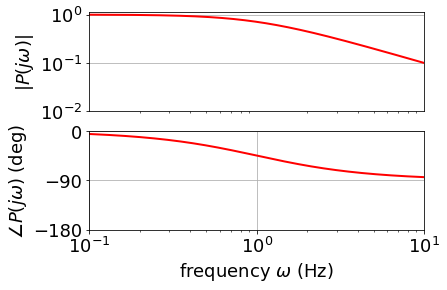

In [52]:
#solution for 3 a.
import numpy as np
from matplotlib import pyplot as plt

R = 1 
C = 1 
P = lambda s : 1. / (1+s*R*C)
w = np.logspace(-1,1,1000)
xlim = w[[0,-1]]
abs_P = np.abs(P(1.j*w))
angle_P = np.unwrap(np.angle(P(1.j*w)))*180./np.pi
plt.figure(); axs = []
ax = plt.subplot(2,1,1); ax.grid(True)
ax.loglog(w,abs_P,'r-',lw=2)
ax.set_ylabel(r'$|P(j\omega)|$')
ax.set_yticks([10**-2,10**-1,10**0])
ax.set_xticks([])
ax.set_xlim(xlim)
axs.append(ax)

ax = plt.subplot(2,1,2); ax.grid(True)
ax.semilogx(w,angle_P,'r-',lw=2)
ax.set_xlabel(r'frequency $\omega$ (Hz)')
ax.set_ylabel(r'$\angle P(j\omega)$ (deg)')
ax.set_yticks([0,-90,-180])
ax.set_xlim(xlim)
axs.append(ax)

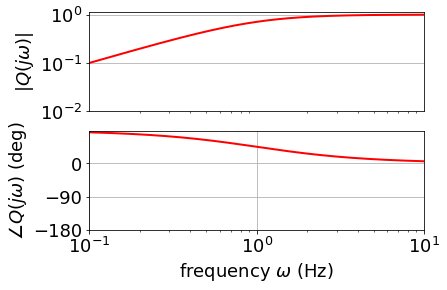

In [53]:
#solution for 3 b.
Q = lambda s : s*R*C/(1+s*R*C)

abs_Q = np.abs(Q(1.j*w))
angle_Q = np.unwrap(np.angle(Q(1.j*w)))*180./np.pi

plt.figure(); axs = []
ax = plt.subplot(2,1,1); ax.grid(True)
ax.loglog(w,abs_Q,'r-',lw=2)
ax.set_ylabel(r'$|Q(j\omega)|$')
ax.set_yticks([10**-2,10**-1,10**0])
ax.set_xticks([])
ax.set_xlim(xlim)
axs.append(ax)

ax = plt.subplot(2,1,2); ax.grid(True)
ax.semilogx(w,angle_Q,'r-',lw=2)
ax.set_xlabel(r'frequency $\omega$ (Hz)')
ax.set_ylabel(r'$\angle Q(j\omega)$ (deg)')
ax.set_yticks([0,-90,-180])
ax.set_xlim(xlim)
axs.append(ax)

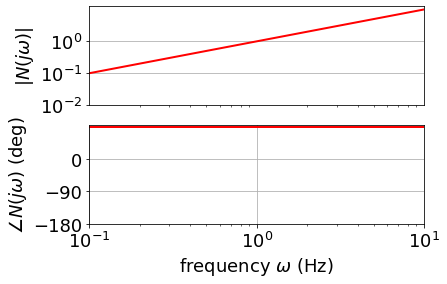

In [54]:
#solution for 3 c.
N = lambda s : s*R*C

abs_N = np.abs(N(1.j*w))
angle_N = np.unwrap(np.angle(N(1.j*w)))*180./np.pi

plt.figure(); axs = []
ax = plt.subplot(2,1,1); ax.grid(True)
ax.loglog(w,abs_N,'r-',lw=2)
ax.set_ylabel(r'$|N(j\omega)|$')
ax.set_yticks([10**-2,10**-1,10**0])
ax.set_xticks([])
ax.set_xlim(xlim)
axs.append(ax)

ax = plt.subplot(2,1,2); ax.grid(True)
ax.semilogx(w,angle_N,'r-',lw=2)
ax.set_xlabel(r'frequency $\omega$ (Hz)')
ax.set_ylabel(r'$\angle N(j\omega)$ (deg)')
ax.set_yticks([0,-90,-180])
ax.set_xlim(xlim)
axs.append(ax)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


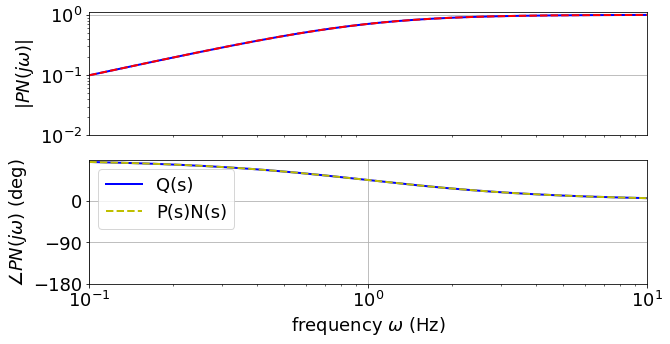

In [55]:
#solution for 3 e.

PN = lambda s : P(s)*N(s)
abs_PN = np.abs(PN(1.j*w))
angle_PN = np.unwrap(np.angle(PN(1.j*w)))*180./np.pi

abs_Q = np.abs(Q(1.j*w))
angle_Q = np.unwrap(np.angle(Q(1.j*w)))*180./np.pi

# plot Q
plt.figure(figsize=(10,5)); axs = []
ax = plt.subplot(2,1,1); ax.grid(True)
ax.loglog(w,abs_Q,'b-',lw=2)
ax.set_ylabel(r'$|Q(j\omega)|$')
ax.set_yticks([10**-2,10**-1,10**0])
ax.set_xticks([])
ax.set_xlim(xlim)
axs.append(ax)

ax = plt.subplot(2,1,2); ax.grid(True)
ax.semilogx(w,angle_Q,'b-',lw=2,label='Q(s)')
ax.set_xlabel(r'frequency $\omega$ (Hz)')
ax.set_ylabel(r'$\angle Q(j\omega)$ (deg)')
ax.set_yticks([0,-90,-180])
ax.set_xlim(xlim)
axs.append(ax)

# plot P(s)N(s)
ax = plt.subplot(2,1,1); ax.grid(True)
ax.loglog(w,abs_PN,'r--',lw=2)
ax.set_ylabel(r'$|PN(j\omega)|$')
ax.set_yticks([10**-2,10**-1,10**0])
ax.set_xticks([])
ax.set_xlim(xlim)
axs.append(ax)

ax = plt.subplot(2,1,2); ax.grid(True)
ax.semilogx(w,angle_PN,'y--',lw=2,label='P(s)N(s)')
ax.set_xlabel(r'frequency $\omega$ (Hz)')
ax.set_ylabel(r'$\angle PN(j\omega)$ (deg)')
ax.set_yticks([0,-90,-180])
ax.set_xlim(xlim)
axs.append(ax)

plt.legend()